In [15]:
# Cell 0 — Install required packages (run once)
!pip install -q nltk scikit-learn matplotlib seaborn wordcloud sentence-transformers transformers evaluate rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 26.1 MB/s eta 0:00:00


In [18]:
# Cell 1 — Imports & settings
import os, re, random
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import pickle

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# dataset path and columns (change here if needed)
DATA_PATH = "/content/medical_data.csv"
TEXT_COL = "TEXT"
LABEL_COL = "DIAGNOSIS"

# nltk downloads (needed)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

plt.style.use('seaborn-v0_8')  # ✅ fixed line



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Cell 2 — Load dataset and quick checks
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing per column:\n", df.isnull().sum())

# ensure TEXT and LABEL exist
if TEXT_COL not in df.columns:
    raise KeyError(f"Text column '{TEXT_COL}' not found. Update TEXT_COL variable.")
# show sample
display(df.head(3))

Loaded: /content/medical_data.csv shape: (744, 7)
Columns: ['SUBJECT_ID', 'ROW_ID', 'HADM_ID', 'CATEGORY', 'ADMISSION_TYPE', 'DIAGNOSIS', 'TEXT']

Missing per column:
 SUBJECT_ID        0
ROW_ID            0
HADM_ID           0
CATEGORY          0
ADMISSION_TYPE    0
DIAGNOSIS         0
TEXT              0
dtype: int64


,SUBJECT_ID,ROW_ID,HADM_ID,CATEGORY,ADMISSION_TYPE,DIAGNOSIS,TEXT
0,26880,178,135453,Discharge summary,EMERGENCY,S/P FALL;TELEMETRY,Admission Date: [**2162-3-3**] Discharge Date: [**2162-3-25**]\n\nDate of Birth: [**2080-1-4**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1828**]\nChief Complaint:\nMr. [**Known lastname 1829**] was seen at [**Hospital1 18**] after a mechanical fall from\na height of 10 feet....
1,42130,181,114236,Discharge summary,ELECTIVE,LEFT SPHENOID MENENGIOMA/SDA,Admission Date: [**2150-2-25**] Discharge Date: [**2150-3-1**]\n\nDate of Birth: [**2086-12-19**] Sex: M\n\nService: NEUROSURGERY\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 1835**]\nChief Complaint:\nleft sided brain lesion\n\nMajor Surgical or Invasive Procedure:\n[**2-25**] Left Craniotomy for mass resection\n\n\...
2,76874,212,113329,Discharge summary,EMERGENCY,TYLENOL BENZO OVERDOSE,"Admission Date: [**2101-10-25**] Discharge Date: [**2101-10-28**]\n\nDate of Birth: [**2064-10-2**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nCephalosporins / Floxin / Penicillins\n\nAttending:[**First Name3 (LF) 2108**]\nChief Complaint:\nXanax, Tylenol & Klonopin Overdose\n\nMajor Surgical or Invasive Procedure:\nNone\n\nHistory of Present Illness:\n37 yo F wi..."


In [20]:
# Cell 3 — Preprocessing
def deidentify(text):
    text = re.sub(r'\[\*.*?\*\]', ' ', str(text))                # [** ... **]
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)                 # emails
    text = re.sub(r'http\S+|www\.\S+', ' <URL> ', text)          # urls
    text = re.sub(r'\b\d{2,}\b', ' <NUM> ', text)                # long numbers -> token
    return text

def clean_text(text):
    t = str(text).lower()
    t = deidentify(t)
    t = re.sub(r'[^a-z0-9\s/.-]', ' ', t)                       # keep some punctuation if needed
    t = re.sub(r'\s+', ' ', t).strip()
    tokens = [w for w in t.split() if w not in STOPWORDS and len(w)>1]
    return " ".join(tokens)

df['text'] = df[TEXT_COL].astype(str)
df['clean'] = df['text'].map(clean_text)
df['len_words'] = df['clean'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)
print("Cleaning done. Sample cleaned text:")
display(df[['text','clean']].head(3))

Cleaning done. Sample cleaned text:


,text,clean
0,Admission Date: [**2162-3-3**] Discharge Date: [**2162-3-25**]\n\nDate of Birth: [**2080-1-4**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1828**]\nChief Complaint:\nMr. [**Known lastname 1829**] was seen at [**Hospital1 18**] after a mechanical fall from\na height of 10 feet....,admission date discharge date date birth sex service medicine allergies patient recorded known allergies drugs attending chief complaint mr. seen mechanical fall height feet. ct scan noted unstable fracture c6-7 posterior elements. major surgical invasive procedure 1. anterior cervical osteotomy c6-c7 decompression excision ossification posterior longitudinal ligament. 2. anterior cervical def...
1,Admission Date: [**2150-2-25**] Discharge Date: [**2150-3-1**]\n\nDate of Birth: [**2086-12-19**] Sex: M\n\nService: NEUROSURGERY\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 1835**]\nChief Complaint:\nleft sided brain lesion\n\nMajor Surgical or Invasive Procedure:\n[**2-25**] Left Craniotomy for mass resection\n\n\...,admission date discharge date date birth sex service neurosurgery allergies known allergies adverse drug reactions attending chief complaint left sided brain lesion major surgical invasive procedure left craniotomy mass resection history present illness -year-old left-handed man follow left sphenoid meningioma. last saw head ct showed growth left sphenoid meningioma. seizure free. today wife d...
2,"Admission Date: [**2101-10-25**] Discharge Date: [**2101-10-28**]\n\nDate of Birth: [**2064-10-2**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nCephalosporins / Floxin / Penicillins\n\nAttending:[**First Name3 (LF) 2108**]\nChief Complaint:\nXanax, Tylenol & Klonopin Overdose\n\nMajor Surgical or Invasive Procedure:\nNone\n\nHistory of Present Illness:\n37 yo F wi...",admission date discharge date date birth sex service medicine allergies cephalosporins floxin penicillins attending chief complaint xanax tylenol klonopin overdose major surgical invasive procedure none history present illness yo history depression suicidal attempt past presented obtundation. note prior attempt years ago od theophylline requiring intubation. feeling depressed last months seein...


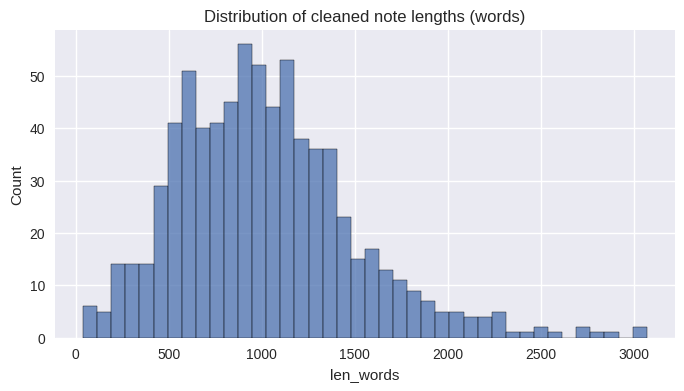

Top label counts:


,count
DIAGNOSIS,
PNEUMONIA,33
SEPSIS,26
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,20
LOWER GI BLEED,17
CONGESTIVE HEART FAILURE,16
GASTROINTESTINAL BLEED,15
ABDOMINAL PAIN,14
UPPER GI BLEED,13
DIABETIC KETOACIDOSIS,10


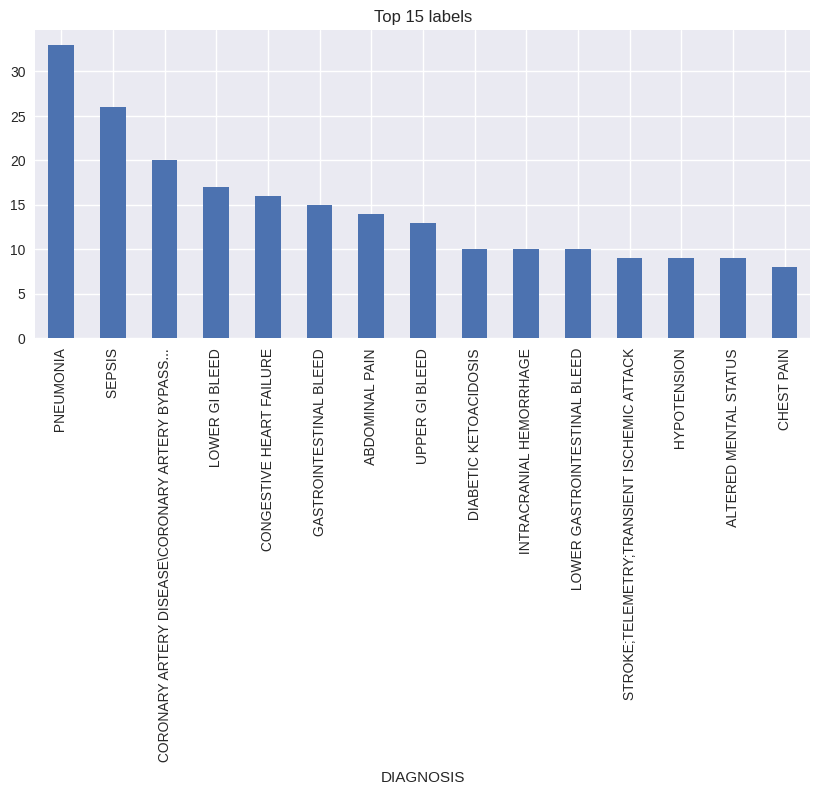

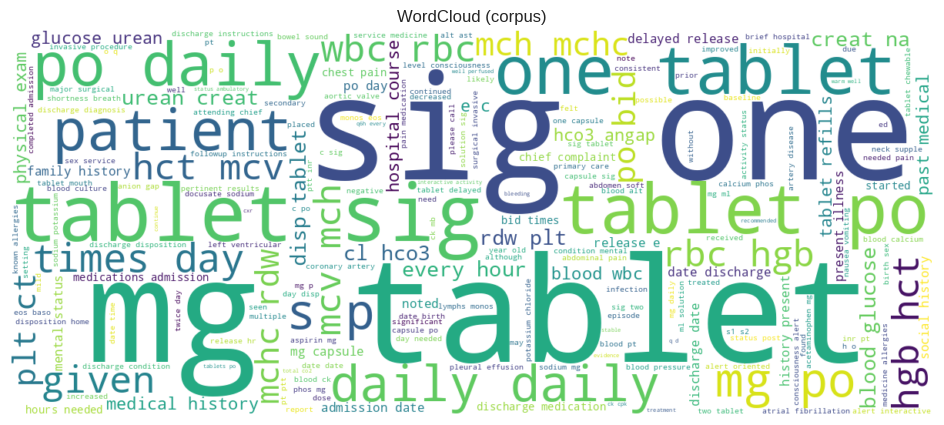

In [21]:
# Cell 4 — EDA: text length distribution, class counts, wordcloud
plt.figure(figsize=(8,4))
sns.histplot(df['len_words'], bins=40)
plt.title("Distribution of cleaned note lengths (words)")
plt.show()

if LABEL_COL in df.columns:
    print("Top label counts:")
    display(df[LABEL_COL].value_counts().head(10))
    plt.figure(figsize=(10,4))
    df[LABEL_COL].value_counts().nlargest(15).plot(kind='bar')
    plt.title("Top 15 labels")
    plt.show()

# WordCloud
corpus = " ".join(df['clean'].dropna().tolist())
if len(corpus.strip())==0:
    print("No tokens for WordCloud (cleaning removed content). Check TEXT_COL.")
else:
    plt.figure(figsize=(12,5))
    wc = WordCloud(width=1200, height=500, background_color='white').generate(corpus)
    plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.title("WordCloud (corpus)")
    plt.show()

In [22]:
# Cell 5 — TF-IDF and split
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
X_all = tfidf.fit_transform(df['clean'].fillna(""))
print("TF-IDF shape:", X_all.shape)

# classification subset: use LABEL_COL if present
if LABEL_COL in df.columns:
    # keep top-K frequent labels to avoid extreme imbalance
    topK = 10
    keep = df[LABEL_COL].value_counts().nlargest(topK).index.tolist()
    df_clf = df[df[LABEL_COL].isin(keep)].copy()
    X = tfidf.transform(df_clf['clean'])
    y = df_clf[LABEL_COL].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    print("Classification set shape:", X_train.shape, X_test.shape)
else:
    print("Label column missing — classification cells will be skipped.")

TF-IDF shape: (744, 4000)
Classification set shape: (139, 4000) (35, 4000)


In [23]:
# Cell 6 — Train classical models & evaluate
if LABEL_COL in df.columns:
    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_nb = nb.predict(X_test)
    print("NaiveBayes Accuracy:", accuracy_score(y_test, y_nb))
    print(classification_report(y_test, y_nb, zero_division=0))

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_lr = lr.predict(X_test)
    print("LogisticRegression Accuracy:", accuracy_score(y_test, y_lr))
    print(classification_report(y_test, y_lr, zero_division=0))
else:
    print("Skipping — no label column.")

NaiveBayes Accuracy: 0.34285714285714286
                                                    precision    recall  f1-score   support

                                    ABDOMINAL PAIN       0.00      0.00      0.00         3
                          CONGESTIVE HEART FAILURE       0.00      0.00      0.00         3
 CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...       1.00      1.00      1.00         4
                             DIABETIC KETOACIDOSIS       0.00      0.00      0.00         2
                            GASTROINTESTINAL BLEED       0.00      0.00      0.00         3
                           INTRACRANIAL HEMORRHAGE       0.00      0.00      0.00         2
                                    LOWER GI BLEED       0.50      0.33      0.40         3
                                         PNEUMONIA       0.24      1.00      0.39         7
                                            SEPSIS       0.00      0.00      0.00         5
                                    UP

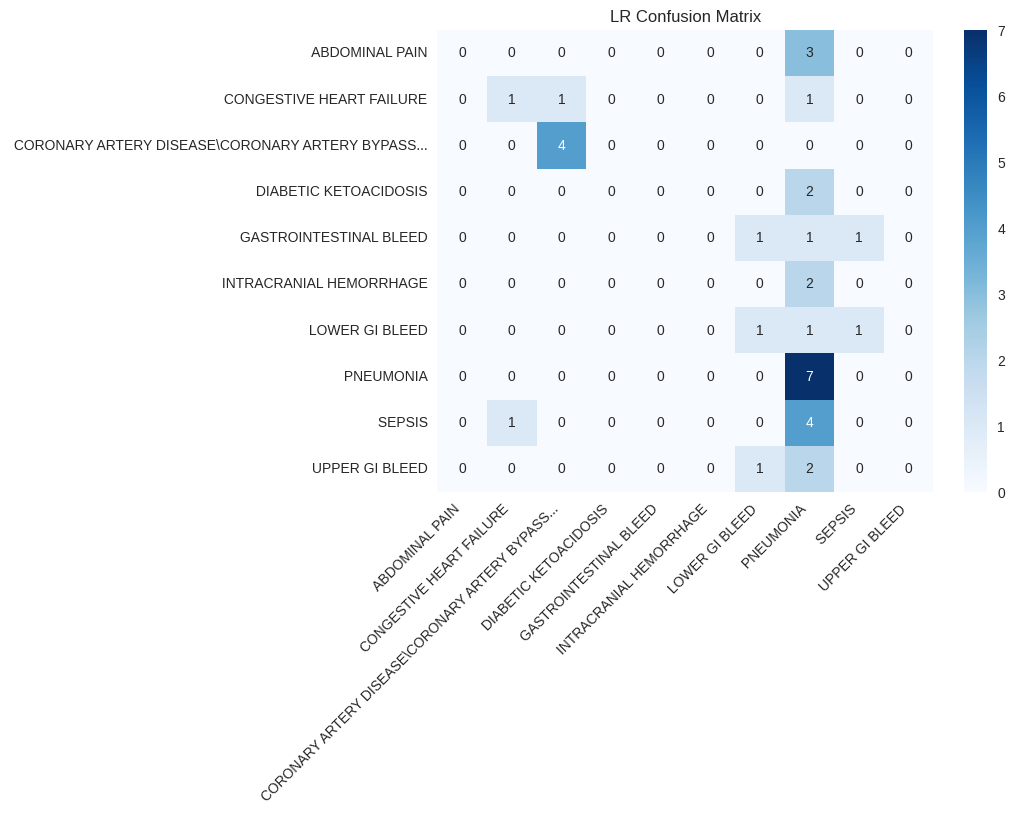


Top features for class ' ABDOMINAL PAIN': pain, gallbladder, abdominal, ercp, abdominal pain, ileostomy, peritoneal, colitis, dialysis, 18pm

Top features for class ' CONGESTIVE HEART FAILURE': heart failure, chf, exacerbation, pulmonary, lasix, ventricular, failure, heart, diastolic, atrial

Top features for class ' CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...': artery, coronary, coronary artery, postoperative, bypass, postoperative day, graft, descending, saphenous vein, saphenous

Top features for class ' DIABETIC KETOACIDOSIS': insulin, dka, pump, ag, diabetic, breakfast, diabetes, dinner, aspiration, nausea

Top features for class ' GASTROINTESTINAL BLEED': mg po, egd, po, bleeding, hematocrit, mg mouth, gi, melena, endoscopy, varices

Top features for class ' INTRACRANIAL HEMORRHAGE': hemorrhage, left, herniation, intraparenchymal, neurosurgery, expired, intubated, temporal, head, husband

Top features for class ' LOWER GI BLEED': colonoscopy, bleeding, colon, bleed, divert

In [24]:
# Cell 7 — Confusion matrix and interpretability
if LABEL_COL in df.columns:
    # Confusion matrix for LR
    cm = confusion_matrix(y_test, y_lr, labels=lr.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=lr.classes_, yticklabels=lr.classes_, cmap='Blues')
    plt.xticks(rotation=45, ha='right'); plt.title("LR Confusion Matrix"); plt.show()

    # Top tf-idf features per class (LR coef)
    feat_names = np.array(tfidf.get_feature_names_out())
    if hasattr(lr, "coef_"):
        for i, cls in enumerate(lr.classes_):
            topn = feat_names[np.argsort(lr.coef_[i])[-10:]][::-1]
            print(f"\nTop features for class '{cls}': {', '.join(topn[:10])}")
else:
    print("Skipping interpretability — no label column.")

In [25]:
# Cell 8 — LDA topic modeling (CountVectorizer -> LDA)
from sklearn.feature_extraction.text import CountVectorizer
n_topics = 6
cv = CountVectorizer(max_features=3000, stop_words='english')
X_counts = cv.fit_transform(df['clean'].fillna(""))
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
lda.fit(X_counts)

words = np.array(cv.get_feature_names_out())
for t in range(n_topics):
    topw = words[np.argsort(lda.components_[t])[-12:]][::-1]
    print(f"\nTopic {t+1}: {', '.join(topw[:12])}")


Topic 1: tablet, mg, po, daily, sig, day, blood, discharge, patient, capsule, admission, history

Topic 2: blood, mg, discharge, patient, po, history, pt, tablet, hct, admission, daily, pain

Topic 3: tablet, mg, po, sig, daily, pain, discharge, day, refills, disp, left, history

Topic 4: patient, mg, day, history, discharge, admission, artery, left, blood, date, coronary, rate

Topic 5: right, left, head, fracture, ct, discharge, pain, mg, patient, neg, hematoma, seizure

Topic 6: left, right, patient, normal, pt, history, blood, discharge, seen, pulmonary, ventricular, family


In [28]:
# === Replacement for Cell 9 (TF-IDF -> SVD -> Clustering) ===
# This avoids sentence-transformers / AutoModel entirely and uses TF-IDF + TruncatedSVD + AgglomerativeClustering.
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Use TF-IDF matrix from earlier (X_all). If not present, build it quickly:
try:
    X_tfidf = X_all
except NameError:
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_tmp = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
    X_tfidf = tfidf_tmp.fit_transform(df['clean'].fillna(""))

# Reduce dimensionality for clustering (fast & memory-friendly)
n_components = 128
svd = TruncatedSVD(n_components=n_components, random_state=SEED)
X_reduced = svd.fit_transform(X_tfidf)
print("SVD reduced shape:", X_reduced.shape)

# Cluster the reduced vectors
n_clusters = 8
cl = AgglomerativeClustering(n_clusters=n_clusters)
cluster_ids = cl.fit_predict(X_reduced)
print("Cluster counts:", np.bincount(cluster_ids))

# Prepare sample texts list (aligned with X_reduced rows)
sample_texts = df['clean'].fillna("").tolist()

# For each cluster, pick a representative text (closest to cluster centroid)
for k in range(n_clusters):
    ids = np.where(cluster_ids == k)[0]
    if len(ids) == 0:
        print(f"\nCluster {k}: empty")
        continue
    centroid = X_reduced[ids].mean(axis=0, keepdims=True)
    sims = cosine_similarity(centroid, X_reduced[ids])[0]
    rep_within = np.argmax(sims)
    rep_idx = ids[rep_within]
    print(f"\nCluster {k} (size {len(ids)}):")
    print("Representative (truncated):", sample_texts[rep_idx][:500].replace("\n"," "))
    # Optionally print a few other short examples
    example_ids = ids[:3]  # first 3 examples
    for ei in example_ids:
        print(" - example:", sample_texts[ei][:200].replace("\n"," "), "...")

SVD reduced shape: (744, 128)
Cluster counts: [116 147 181  47  74 111  28  40]

Cluster 0 (size 116):
Representative (truncated): admission date discharge date date birth sex service neurosurgery allergies patient recorded known allergies drugs attending chief complaint elective admission open craniotomy p-comm aneurysm resection major surgical invasive procedure craniotomy p-comm aneurysm clipping history present illness patient 62f history migraines evalutated mri found posterior communicating artery aneurysm associated enlargement pituitary gland. past medical history 1. s/p ccy 2. cervical dysplasia 3. hypertension 4. 
 - example: admission date discharge date date birth sex service medicine allergies patient recorded known allergies drugs attending chief complaint mr. seen mechanical fall height feet. ct scan noted unstable fr ...
 - example: admission date discharge date date birth sex service neurosurgery allergies known allergies adverse drug reactions attending chief complain

In [29]:
# Cell 10 — Pretrained summarization demo (facebook/bart-large-cnn)
device = 0 if __import__("torch").cuda.is_available() else -1
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn", device=device)
# pick 3 medium-length notes to demo
candidates = df.sort_values('len_words')['len_words'].index.tolist()
demo_idxs = [i for i in candidates if df.loc[i,'len_words']>40][:3]  # pick notes >40 words
if not demo_idxs:
    demo_idxs = candidates[:3]
for idx in demo_idxs:
    text = df.loc[idx, 'text']
    print("\n--- Original (truncated) ---\n", text[:800], "...\n")
    try:
        summ = summarizer(text, max_length=120, min_length=20, do_sample=False)[0]['summary_text']
        print("Summary:\n", summ)
    except Exception as e:
        print("Summarizer error:", e)

config.json: 0.00B [00:00, ?B/s]

🚨 `head_mask` is part of BartModel.forward's signature, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/models/bart/modeling_bart.py.
🚨 `decoder_head_mask` is part of BartModel.forward's signature, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/models/bart/modeling_bart.py.
🚨 `head_mask` is part of BartForConditionalGeneration.forward's signature, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/models/bart/modeling_bart.py.
🚨 `decoder_head_mask` is part of BartForConditionalGeneration.forward's signature, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/models/bart/modeling_bart.py.
🚨 `head_mask` is part of BartForSequenceClassification.forward's signature, but not do

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu



--- Original (truncated) ---
 Admission Date:  [**2132-1-3**]       Discharge Date:  [**2132-1-9**]

Date of Birth:   [**2061-2-1**]       Sex:  F

Service:

                    ADDENDUM

HOSPITAL COURSE:  The patient is being discharged on [**2132-1-9**], after clearance by Physical Therapy as a level 5.
She has a urinalysis which came back positive.  She is being
discharged with Cipro 500 mg p.o. b.i.d. for 3 days for
treatment of the urinary tract infection.

DISCHARGE MEDICATIONS:  Lopressor 50 p.o. b.i.d., Protonix 40
p.o. q.d., Percocet [**11-21**] tab for pain, given 40 tab, Colace
100 mg p.o. b.i.d., Aspirin 325 mg p.o. once a day, Lasix 20
mg b.i.d., KCl 20 mEq p.o. b.i.d. for one week.

CONDITION ON DISCHARGE:  Good.

FOLLOW-UP:  She is to follow-up with her primary care
physician [**Last Name (NamePattern4)  ...

Summarizer error: '<' not supported between instances of 'NoneType' and 'int'

--- Original (truncated) ---
 Admission Date:  [**2168-12-21**]       Discharge Date

In [30]:
# Cell 11 — Save cleaned data, TF-IDF, models, and predictions
out_clean = "/content/clinical_notes_cleaned.csv"
df.to_csv(out_clean, index=False)
print("Saved cleaned data ->", out_clean)

# Save TF-IDF vectorizer
with open("/content/tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(tfidf, f)
print("Saved TF-IDF vectorizer -> /content/tfidf_vectorizer.pkl")

# Save classical models (if trained)
try:
    with open("/content/nb_model.pkl","wb") as f:
        pickle.dump(nb, f)
    with open("/content/lr_model.pkl","wb") as f:
        pickle.dump(lr, f)
    print("Saved NB & LR models -> /content/*.pkl")
except Exception:
    print("Models not saved (maybe classifiers not trained).")

# Save classification predictions (if available)
if LABEL_COL in df.columns:
    X_all_keep = tfidf.transform(df_clf['clean'])
    preds = lr.predict(X_all_keep)
    df_clf_out = df_clf.copy()
    df_clf_out['predicted'] = preds
    preds_path = "/content/predictions_tfidf_lr.csv"
    df_clf_out[['text', LABEL_COL, 'predicted']].to_csv(preds_path, index=False)
    print("Saved predictions ->", preds_path)

Saved cleaned data -> /content/clinical_notes_cleaned.csv
Saved TF-IDF vectorizer -> /content/tfidf_vectorizer.pkl
Saved NB & LR models -> /content/*.pkl
Saved predictions -> /content/predictions_tfidf_lr.csv
